In [1]:
import mxnet as mx
from mxnet import gluon, nd, autograd
from mxnet.gluon import nn, utils
import numpy as np
import os
import tarfile
import matplotlib.image as mpimg
import matplotlib as mpl
from matplotlib import pyplot as plt
from time import time
%matplotlib inline
ctx = mx.gpu()
data_dir = '/home/sinyer/python/data/gan'

In [2]:
def load_data():  
    lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
    data_path = data_dir + '/lfw_dataset'
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        data_file = utils.download(lfw_url)
        with tarfile.open(data_file) as tar:
            tar.extractall(path=data_path)
    img_list = []
    for path, _, fnames in os.walk(data_path):
        for fname in fnames:
            if not fname.endswith('.jpg'):
                continue
            img = os.path.join(path, fname)
            img_arr = mx.image.imread(img)
            img_arr = transform(img_arr)
            img_list.append(img_arr)
    train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)
    return train_data

def transform(data):
    data = mx.image.imresize(data, 64, 64)
    data = nd.transpose(data, (2,0,1))
    data = data.astype(np.float32)/127.5 - 1
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

In [3]:
batch_size = 64

train_data = load_data()
real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,), ctx=ctx)

In [4]:
netG = nn.Sequential()
with netG.name_scope():
    netG.add(nn.Conv2DTranspose(512, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    netG.add(nn.Conv2DTranspose(256, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    netG.add(nn.Conv2DTranspose(128, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    netG.add(nn.Conv2DTranspose(64, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    netG.add(nn.Conv2DTranspose(3, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))

netD = nn.Sequential()
with netD.name_scope():
    netD.add(nn.Conv2D(64, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    netD.add(nn.Conv2D(128, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    netD.add(nn.Conv2D(256, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    netD.add(nn.Conv2D(512, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

In [5]:
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': 2e-4, 'beta1': 0.5})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': 2e-4, 'beta1': 0.5})

In [6]:
epochs = 100

for epoch in range(epochs):
    start = time()
    train_data.reset()
    for batch in train_data:
        data = batch.data[0].as_in_context(ctx)
        latent_z = nd.random_normal(0, 1, shape=(batch_size, 100, 1, 1), ctx=ctx)
        with autograd.record():
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            fake = netG(latent_z)
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
        trainerD.step(batch.data[0].shape[0])
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()
        trainerG.step(batch.data[0].shape[0])

    print('%d, dloss %.4f, gloss %.4f, T %.4f' %(
        epoch, nd.mean(errD).asscalar(), nd.mean(errG).asscalar(), time()-start))

0, dloss 0.7648, gloss 9.9508, T 19.3507
1, dloss 0.4750, gloss 7.7703, T 14.1488
2, dloss 0.3520, gloss 4.6689, T 14.2108
3, dloss 0.3714, gloss 6.2483, T 14.2585
4, dloss 1.2852, gloss 6.2802, T 14.3287
5, dloss 0.2178, gloss 5.6122, T 14.3842
6, dloss 0.1855, gloss 3.6447, T 14.5211
7, dloss 0.5246, gloss 6.5644, T 14.6418
8, dloss 1.1444, gloss 10.9547, T 14.6763
9, dloss 0.1977, gloss 4.4193, T 14.8294
10, dloss 0.4562, gloss 4.0105, T 14.6970
11, dloss 0.2290, gloss 4.6091, T 14.8421
12, dloss 0.3505, gloss 3.4610, T 14.7112
13, dloss 0.6388, gloss 7.0825, T 14.7675
14, dloss 0.4523, gloss 5.2973, T 14.7501
15, dloss 1.6180, gloss 7.7477, T 14.7607
16, dloss 0.2720, gloss 3.8735, T 14.8066
17, dloss 0.4311, gloss 4.2720, T 14.8807
18, dloss 0.3267, gloss 4.0236, T 14.9063
19, dloss 1.6406, gloss 6.5126, T 14.8191
20, dloss 0.3300, gloss 3.8764, T 14.7128
21, dloss 0.3666, gloss 3.4712, T 14.9153
22, dloss 0.9287, gloss 6.7739, T 14.8066
23, dloss 1.7444, gloss 5.9866, T 14.8057
2

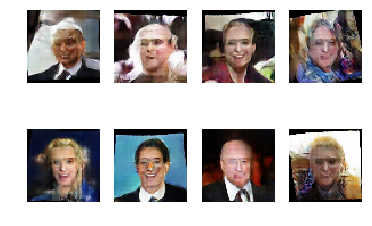

In [7]:
num_image = 8

for i in range(num_image):
    latent_z = nd.random_normal(0, 1, shape=(1, 100, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()